# Integration of BCR data and GEX data

## Introduction

10x BCR (B cell receptor) data and 10x GEX (gene expression) data can borrow information from each other for an improved analysis. This tutorial demonstrates a few approaches to integrating these data types along with examples on how the new information can be used. 

The example dataset used in this tutorial is from the following paper:

Turner JS, Zhou JQ, Han J, Schmitz AJ, Rizk AA, Alsoussi WB, Lei T, Amor M, McIntire KM, Meade P, Strohmeier S, Brent RI, Richey ST, Haile A, Yang YR, Klebert MK, Suessen T, Teefey S, Presti RM, Krammer F, Kleinstein SH, Ward AB, Ellebedy AH. Human germinal centres engage memory and naive B cells after influenza vaccination. Nature. 2020 Oct;586(7827):127-132. doi: 10.1038/s41586-020-2711-0. Epub 2020 Aug 31. PMID: 32866963; PMCID: PMC7566073.

We extracted a subset (~3000 cells) of single cell GEX/BCR data of ultrasound-guided fine needle aspiration (FNA) samples of lymphnodes for subject P05. The example dataset (BCR.data.rds and GEX.data.rds) can be downloaded in a zip file from here.

In [98]:
# make sure the environment is clear
rm(list = ls())

# show some useful information
cat(R.Version()$version.string,
    paste("Platform:", R.Version()$platform),
    paste("Running under:", sessionInfo()$running),
    sep = "\n")
cat("\n")

# load the required packages
packages <- c("dplyr", "ggplot2", "Seurat")
for (n in 1:length(packages)) {
    suppressPackageStartupMessages(library(packages[n], character.only = TRUE))
    cat(paste0(packages[n], ": ", packageVersion(packages[n]), "\n"))
}

# set the data directory
path_data <- file.path("..", "data") # change this to fit your own directory structure

In [99]:
# read in the data
gex_obj <- readRDS(file.path(path_data, "GEX.data.rds"))
bcr_data <- readRDS(file.path(path_data, "BCR.data.rds"))

# extract heavy chains from BCR data
bcr_data <- bcr_data %>% rowwise() %>%
            filter(locus=="IGH")

In this tutorial, we will integrate the BCR and GEX data by using the cell barcodes. However, since cell barcodes can be duplicated in multiple samples, we suggest concatenating the sample ids with the cell ids in order to ensure the uniqueness of cell barcodes across multiple samples. The sample ids can be added as a prefix to the existing cell ids when the GEX data is being processed with a Seurat command such as gex_obj <- RenameCells(object = gex_obj, add.cell.id = sample).

Note: We have already added the sample ids to the cell ids as such in the example GEX and BCR data.

## Integration of BCR data with the GEX Seurat object

The meta.data data slot in the Seurat object contains metadata for each cell and is a good place to hold information from BCR data. * For example, we can indicate if a cell in the GEX data has a corresponding BCR or not by adding a column called “contains_bcr”. * If the column “has_BCR” is true, then we can add other useful BCR data information such as clonal lineage, mutation frequency, isotype, etc. to the metadata slot. * The new columns in Seurat object use names defined by the AIRR standard, but prefixed with “bcr_”.*

### Create the new metadata columns

In [100]:
new_meta_cols <- data.frame(cell_id_unique = Cells(gex_obj))

# select columns from BCR data
bcr_data_selected <- bcr_data %>% select(cell_id_unique, clone_id, mu_freq, isotype) %>%
                     rename(bcr_clone_id = clone_id,
                            bcr_mu_freq = mu_freq,
                            bcr_isotype = isotype)

# sort BCR data by cell id in GEX Seurat Object
new_meta_cols <- left_join(new_meta_cols, bcr_data_selected, by = 'cell_id_unique')

# integrate BCR data with the Seurat object
for (colname in colnames(bcr_data_selected)) {
   gex_obj[[colname]] = new_meta_cols[[colname]]
}
gex_obj$contains_bcr <- !is.na(gex_obj$bcr_clone_id)

# examples of the new columns
ncol_meta <- ncol(gex_obj[[]])
gex_obj[[]][, (ncol_meta-3):ncol_meta] %>% slice_sample(n = 5) # row names = cell ids

,bcr_clone_id,bcr_mu_freq,bcr_isotype,contains_bcr
,<int>,<dbl>,<chr>,<lgl>
P05_FNA_d120_4_Y2_ATGGGAGCATTCTCAT-1,NA,NA,NA,FALSE
P05_FNA_d28_3_Y2_ACGCCGAGTCGCGGTT-1,49282,0.034364261,IgM,TRUE
P05_FNA_d28_1_Y2_CCTAAAGGTAGCGTGA-1,22516,0.065972222,IgG,TRUE
P05_FNA_d120_1_Y2_CGCTTCAGTCGAGATG-1,NA,NA,NA,FALSE
P05_FNA_d28_2_Y2_ATAACGCCACTGTCGG-1,63531,0.003472222,IgM,TRUE


### Highlight BCR cells in the GEX UMAP¶

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


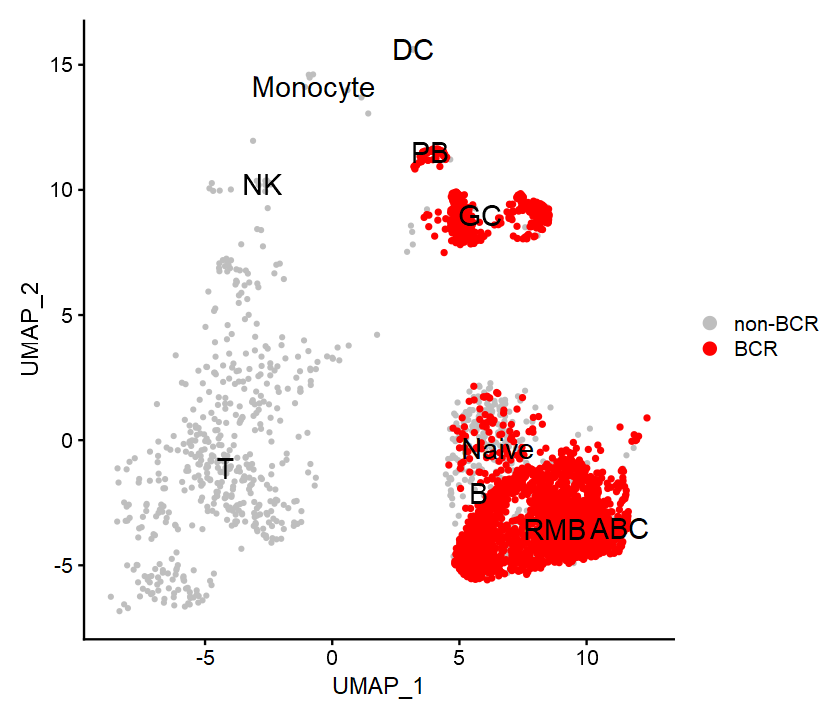

In [101]:
highlighted_cells <- Cells(gex_obj)[which(gex_obj$contains_bcr)]

options(repr.plot.width = 7, repr.plot.height = 6)
UMAPPlot(object = gex_obj, cells.highlight = highlighted_cells,
         label = TRUE, label.size = 6, pt.size = 0.7) +
scale_color_manual(labels = c("non-BCR", "BCR"), values = c("gray", "red"))

As we can see, there is a very good correlation between the BCR cells (in red) and the clusters labeled as B cells.

UMAP labels note: DC = dendritic cells, GC = germinal center B cells, NK = natural killer cells, PB = plasmablasts, RMB = resting memory B cells, ABC = active B cells

## Integration of GEX cell annotations in the BCR data

The annotatation information of B cells (such as sub-types of B cells and their associated UMAP coordinates) identified by the GEX data can be integrated into BCR data.

### Add GEX information to the BCR data

The annotation information of B cells, such as subtypes of B cells and their associated UMAP coordinates, identified by the gene expression data from 10x GEX, can be integrated into BCR data.

In [102]:
# select columns from the GEX data
gex_data_selected <- data.frame(cell_id_unique = Cells(gex_obj),
                                gex_umap_1 = gex_obj@reductions$umap@cell.embeddings[,1],
                                gex_umap_2 = gex_obj@reductions$umap@cell.embeddings[,2],
                                gex_annotation = as.character(Idents(gex_obj)))

# integrate GEX data with the BCR data
bcr_gex_data <- left_join(bcr_data, gex_data_selected, by = 'cell_id_unique')

# keep BCR cells has matched cells from GEX data
bcr_gex_data <- filter(bcr_gex_data, !is.na(gex_annotation))

# examples of the new columns
ncol_bcr_gex <- ncol(bcr_gex_data)
head(bcr_gex_data[, (ncol_bcr_gex-3):ncol_bcr_gex])

locus,gex_umap_1,gex_umap_2,gex_annotation
<chr>,<dbl>,<dbl>,<chr>
IGH,6.162098,-2.866248,RMB
IGH,5.398692,-4.991450,RMB
IGH,5.708583,-3.587786,RMB
IGH,7.503206,9.614720,GC
IGH,8.236542,-3.948731,RMB
IGH,10.850370,-4.393985,ABC


### Identify GEX clusters in the BCR UMAP

Using the annotated information, we can layout cells from the BCR data in a UMAP plot color-coded by the B cell subtypes.

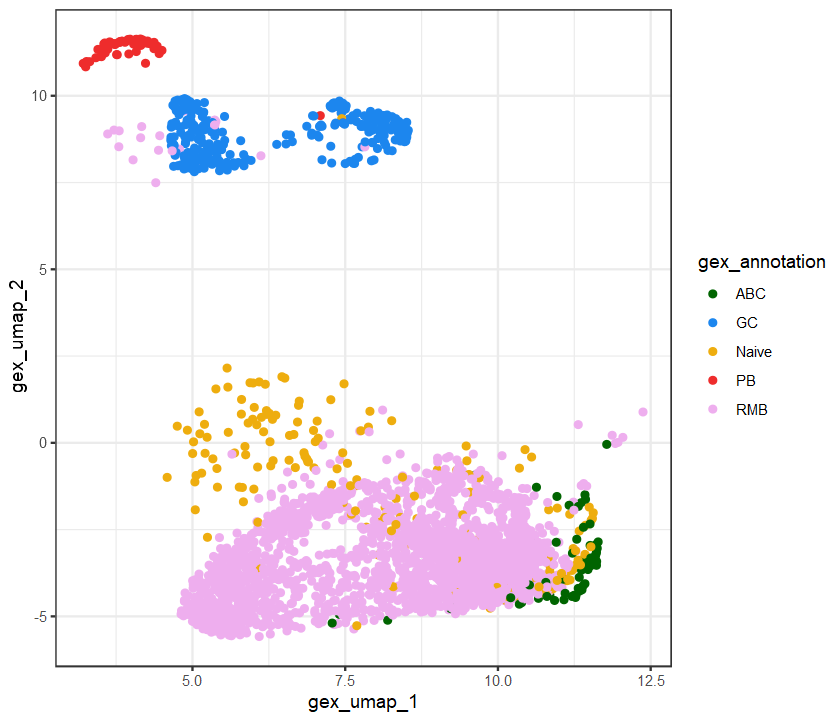

In [103]:
anno_cols <- c("GC" = "dodgerblue2", "Naive" = "darkgoldenrod2", "PB" = "firebrick2", "RMB" = "plum2", "ABC"="darkgreen")

options(repr.plot.width = 7, repr.plot.height = 6)
ggplot() + geom_point(data = bcr_gex_data, aes(x = gex_umap_1, y = gex_umap_2, color = gex_annotation)) +
           scale_colour_manual(values = anno_cols) + theme_bw()

Characteristics associated with BCR can be displayed in umap plot. The plots below show mutation frequency and isotypes of GC B cells at various time points.

### Other BCR features in UMAPs

Characteristics associated with the BCR can also be displayed in UMAP plots. The plots below show the mutation frequencies and isotypes of GC B cells at various time points.

In [104]:
options(repr.plot.width = 16, repr.plot.height = 4)

# base plot
p <- ggplot() + geom_point(data = filter(bcr_gex_data, gex_annotation != "GC"),
                           aes(x = gex_umap_1, y = gex_umap_2), color = "lightgray", size = 1) +
                theme_bw() + facet_wrap(~day, nrow = 1)

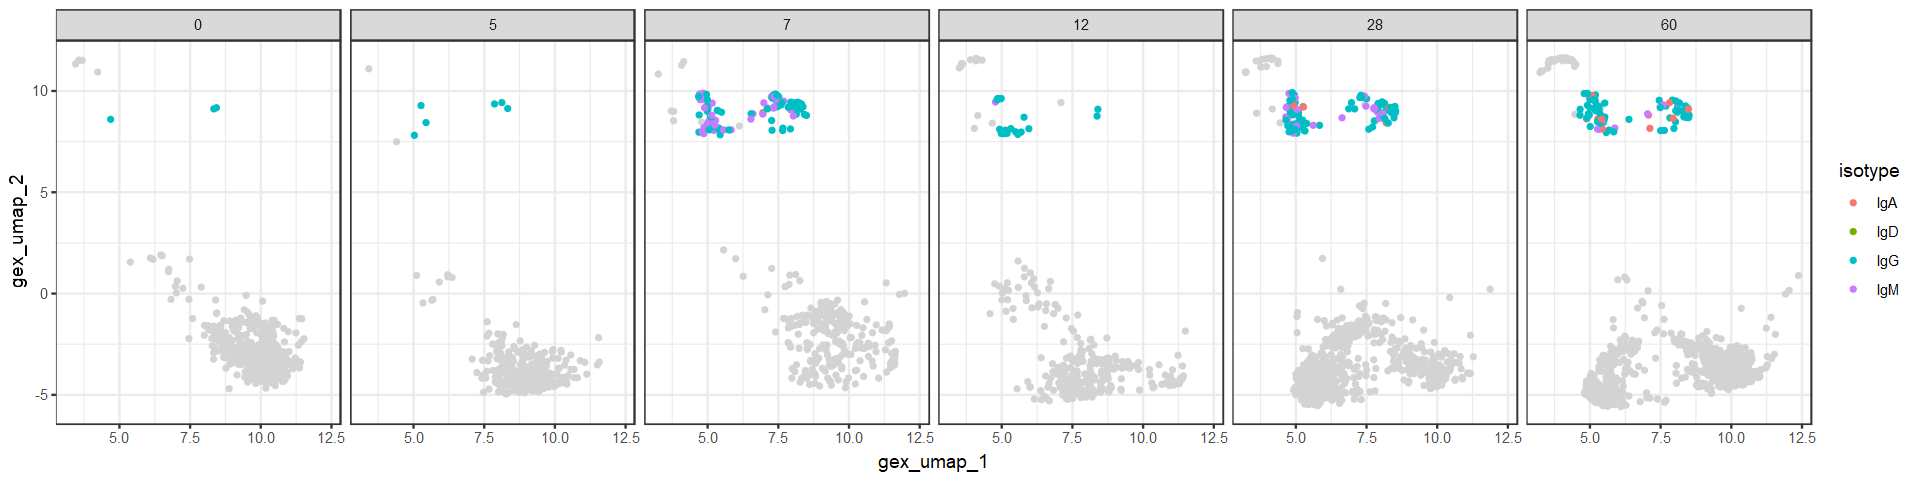

In [105]:
# isotype information
p + geom_point(data = filter(bcr_gex_data, gex_annotation == "GC"),
               aes(x = gex_umap_1, y = gex_umap_2, color = isotype), size = 1)

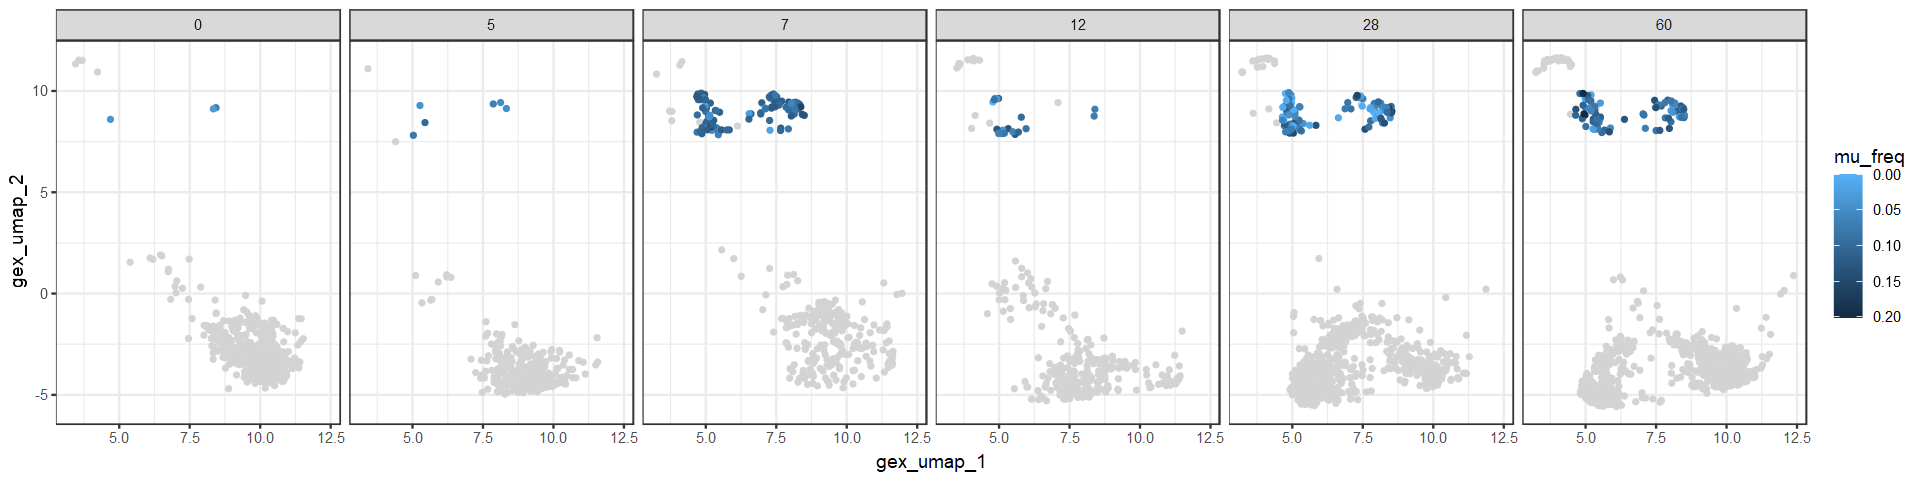

In [106]:
# mutation frequency
p + geom_point(data = filter(bcr_gex_data, gex_annotation == "GC"),
               aes(x = gex_umap_1, y = gex_umap_2, color = mu_freq), size = 1) +
    scale_colour_continuous(trans = 'reverse')

## 